In [43]:
# imports
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Data import MelSpecDataset
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torch import optim
from torchvision.models import vgg16
from torchvision.transforms import v2
from CNNModel import CNN
import matplotlib.pyplot as plt

In [44]:
# train model for one epoch
def train_one_epoch(model, optimizer, loss_fn, train_loader):
    model.train()
    for batch, (x, y) in enumerate(train_loader):
        # feed forward
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'BATCH {batch}, LOSS {loss.item()}')

# returns loss, accuracy, precision, and recall
def test_model(model, loss_fn, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    for x, y in test_loader:
        # feed forward
        y_pred.append(model(x).argmax(dim=1))
        y_true.append(y)
        loss = loss_fn(model(x), y)
        total_loss += loss.item()
    
    # gather predictions and true labels
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    
    # calculate metrics
    loss, acc, prec, recall, f1 = (
        total_loss, accuracy_score(y_true, y_pred), 
        precision_score(y_true, y_pred, average='macro'), 
        recall_score(y_true, y_pred, average='macro'), 
        f1_score(y_true, y_pred, average='macro')
    )
    print(f'LOSS {loss}, ACCURACY {acc}, PRECISION {prec}, RECALL {recall}, F1 {f1}')
    return loss, acc, prec, recall, f1

# k-fold cross validation
def k_fold(model_class, train_data, num_epochs, batch_size, checkpoint_path):
    # split data and iterate over folds
    kf = KFold(n_splits=5, shuffle=True)
    for fold, (train, test) in enumerate(kf.split(train_data)):
        print(f'FOLD {fold}')
        
        # prepare data
        train = SubsetRandomSampler(train)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train)
        test = SubsetRandomSampler(test)
        test_loader = DataLoader(train_data, batch_size=batch_size, sampler=test)
        
        # initialize model
        model = model_class()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
        
        # train model
        for epoch in range(num_epochs):
            print(f'EPOCH {epoch}')
            
            train_one_epoch(model, optimizer, loss_fn, train_loader)

            # test model
            loss, accuracy, precision, recall, f1 = test_model(model, loss_fn, test_loader)
            
            # save checkpoint
            torch.save({
                'fold': fold,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
            }, f'{checkpoint_path}/fold{fold}_epoch{epoch}.pt')

In [45]:
# VGG 16
transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    lambda x: x.repeat(3, 1, 1),
])
train_data = MelSpecDataset(transforms)
train_data = Subset(train_data, range(0, len(train_data), 15)) # reduce data size
k_fold(vgg16, train_data, num_epochs=32, batch_size=64, checkpoint_path='vgg_checkpoints')

FOLD 0
EPOCH 0
BATCH 0, LOSS 766.5882568359375
BATCH 1, LOSS 13982748377088.0
BATCH 2, LOSS 38792500.0
BATCH 3, LOSS 9169476608.0
BATCH 4, LOSS 81978584.0
BATCH 5, LOSS 289921344.0
BATCH 6, LOSS 3738515968.0
BATCH 7, LOSS 690316544.0
BATCH 8, LOSS 10206905.0
BATCH 9, LOSS 55743868.0
BATCH 10, LOSS 57236736.0
BATCH 11, LOSS 2247042.0
BATCH 12, LOSS 28075054.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 4971927.03125, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
EPOCH 1
BATCH 0, LOSS 1988017.25
BATCH 1, LOSS 2927564.25
BATCH 2, LOSS 66015068.0
BATCH 3, LOSS 5460167.0
BATCH 4, LOSS 610639.625
BATCH 5, LOSS 1011015.6875
BATCH 6, LOSS 4278128.0
BATCH 7, LOSS 1026111.625
BATCH 8, LOSS 410133.6875
BATCH 9, LOSS 898969.0
BATCH 10, LOSS 592106.0
BATCH 11, LOSS 5112422.0
BATCH 12, LOSS 3077619.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 6734466.5, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
EPOCH 2
BATCH 0, LOSS 7765083.0
BATCH 1, LOSS 12890918.0
BATCH 2, LOSS 5267704.0
BATCH 3, LOSS 2257366.5
BATCH 4, LOSS 6590.5859375
BATCH 5, LOSS 4553.564453125
BATCH 6, LOSS 6015.9716796875
BATCH 7, LOSS 4961.7841796875
BATCH 8, LOSS 31146.373046875
BATCH 9, LOSS 23575.1953125
BATCH 10, LOSS 139704.875
BATCH 11, LOSS 32493.4140625
BATCH 12, LOSS 12251.14453125


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 41727.551513671875, ACCURACY 0.40298507462686567, PRECISION 0.13432835820895522, RECALL 0.3333333333333333, F1 0.1914893617021277
EPOCH 3
BATCH 0, LOSS 28568.78515625
BATCH 1, LOSS 12823.490234375
BATCH 2, LOSS 108501352.0
BATCH 3, LOSS 477300.0625
BATCH 4, LOSS 542790.0
BATCH 5, LOSS 1132345.25
BATCH 6, LOSS 437564.5
BATCH 7, LOSS 353116.5
BATCH 8, LOSS 126599.1015625
BATCH 9, LOSS 39515.0390625
BATCH 10, LOSS 17029.921875
BATCH 11, LOSS 16738.568359375
BATCH 12, LOSS 286412.6875


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 53733.84765625, ACCURACY 0.26865671641791045, PRECISION 0.08955223880597014, RECALL 0.3333333333333333, F1 0.1411764705882353
EPOCH 4
BATCH 0, LOSS 18529.6015625
BATCH 1, LOSS 12482.876953125
BATCH 2, LOSS 10065.10546875
BATCH 3, LOSS 8277.9951171875
BATCH 4, LOSS 8335.65234375
BATCH 5, LOSS 11501.0927734375
BATCH 6, LOSS 12464.42578125
BATCH 7, LOSS 9218.26171875
BATCH 8, LOSS 7284.92822265625
BATCH 9, LOSS 6884.62353515625
BATCH 10, LOSS 6137.9833984375
BATCH 11, LOSS 9325.904296875
BATCH 12, LOSS 2674.836181640625


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 7499.976531982422, ACCURACY 0.40298507462686567, PRECISION 0.13432835820895522, RECALL 0.3333333333333333, F1 0.1914893617021277
EPOCH 5
BATCH 0, LOSS 8178.5908203125
BATCH 1, LOSS 4733.03466796875
BATCH 2, LOSS 4264.4853515625
BATCH 3, LOSS 3348.28369140625
BATCH 4, LOSS 2217.4208984375
BATCH 5, LOSS 2255.9130859375
BATCH 6, LOSS 2485.933837890625
BATCH 7, LOSS 1447.3751220703125
BATCH 8, LOSS 1747.1595458984375
BATCH 9, LOSS 1310.640869140625
BATCH 10, LOSS 1154.821533203125
BATCH 11, LOSS 1014.1822509765625
BATCH 12, LOSS 555.1126098632812


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1309.866065979004, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
EPOCH 6
BATCH 0, LOSS 1022.6119995117188
BATCH 1, LOSS 849.3935546875
BATCH 2, LOSS 918.9404907226562
BATCH 3, LOSS 723.2247924804688
BATCH 4, LOSS 771.0185546875
BATCH 5, LOSS 683.2235107421875
BATCH 6, LOSS 655.18603515625
BATCH 7, LOSS 759.9346923828125
BATCH 8, LOSS 425.3819885253906
BATCH 9, LOSS 371.856689453125
BATCH 10, LOSS 344.2692565917969
BATCH 11, LOSS 382.2185363769531
BATCH 12, LOSS 170.88552856445312


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 382.12541007995605, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
EPOCH 7
BATCH 0, LOSS 322.0190734863281
BATCH 1, LOSS 260.2029113769531
BATCH 2, LOSS 413.0107116699219
BATCH 3, LOSS 390.596923828125
BATCH 4, LOSS 237.73414611816406
BATCH 5, LOSS 248.2224578857422
BATCH 6, LOSS 240.0790557861328
BATCH 7, LOSS 206.50387573242188
BATCH 8, LOSS 233.27061462402344
BATCH 9, LOSS 172.74070739746094
BATCH 10, LOSS 141.3751678466797
BATCH 11, LOSS 136.22496032714844
BATCH 12, LOSS 79.4161148071289


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 292.36438751220703, ACCURACY 0.26865671641791045, PRECISION 0.08955223880597014, RECALL 0.3333333333333333, F1 0.1411764705882353
EPOCH 8
BATCH 0, LOSS 163.3335418701172
BATCH 1, LOSS 157.17373657226562
BATCH 2, LOSS 134.04518127441406
BATCH 3, LOSS 138.97900390625
BATCH 4, LOSS 120.55915832519531
BATCH 5, LOSS 149.87078857421875
BATCH 6, LOSS 177.3079071044922
BATCH 7, LOSS 129.7601318359375
BATCH 8, LOSS 125.31571960449219
BATCH 9, LOSS 114.16072082519531
BATCH 10, LOSS 110.79753875732422
BATCH 11, LOSS 86.75137329101562
BATCH 12, LOSS 47.133358001708984


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 233.56530666351318, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
EPOCH 9
BATCH 0, LOSS 103.37074279785156
BATCH 1, LOSS 91.96856689453125
BATCH 2, LOSS 105.02476501464844
BATCH 3, LOSS 109.41555786132812
BATCH 4, LOSS 88.74687957763672
BATCH 5, LOSS 108.97896575927734
BATCH 6, LOSS 89.07572937011719
BATCH 7, LOSS 87.66000366210938
BATCH 8, LOSS 166.83203125
BATCH 9, LOSS 84.30852508544922
BATCH 10, LOSS 92.71698760986328
BATCH 11, LOSS 129.06703186035156
BATCH 12, LOSS 54.209388732910156


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 233.13164138793945, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
EPOCH 10
BATCH 0, LOSS 110.10734558105469
BATCH 1, LOSS 114.94038391113281
BATCH 2, LOSS 81.4103012084961
BATCH 3, LOSS 103.75145721435547
BATCH 4, LOSS 121.3863296508789
BATCH 5, LOSS 116.60587310791016
BATCH 6, LOSS 123.13936614990234
BATCH 7, LOSS 83.33963012695312
BATCH 8, LOSS 98.40140533447266
BATCH 9, LOSS 104.01203155517578
BATCH 10, LOSS 104.43623352050781
BATCH 11, LOSS 121.74789428710938
BATCH 12, LOSS 62.39140319824219


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 229.73744773864746, ACCURACY 0.40298507462686567, PRECISION 0.13432835820895522, RECALL 0.3333333333333333, F1 0.1914893617021277
EPOCH 11
BATCH 0, LOSS 122.09428405761719
BATCH 1, LOSS 88.41964721679688
BATCH 2, LOSS 93.60816955566406
BATCH 3, LOSS 90.99813842773438
BATCH 4, LOSS 92.38192749023438
BATCH 5, LOSS 76.4085464477539
BATCH 6, LOSS 83.29621124267578
BATCH 7, LOSS 79.86934661865234
BATCH 8, LOSS 86.2437744140625
BATCH 9, LOSS 96.91018676757812
BATCH 10, LOSS 81.43505859375
BATCH 11, LOSS 75.52303314208984
BATCH 12, LOSS 47.398193359375


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 239.8207607269287, ACCURACY 0.3283582089552239, PRECISION 0.10945273631840796, RECALL 0.3333333333333333, F1 0.1647940074906367
FOLD 1
EPOCH 0
BATCH 0, LOSS 923.6198120117188
BATCH 1, LOSS 5252564647936.0
BATCH 2, LOSS 2814854.75
BATCH 3, LOSS 174788016.0
BATCH 4, LOSS 21163306.0
BATCH 5, LOSS 359800320.0
BATCH 6, LOSS 97907646464.0
BATCH 7, LOSS 70987980800.0
BATCH 8, LOSS 35175436.0
BATCH 9, LOSS 38203436.0
BATCH 10, LOSS 29823984.0
BATCH 11, LOSS 2047588224.0
BATCH 12, LOSS 8024771.5


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 293611224.0, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 1
BATCH 0, LOSS 98233768.0
BATCH 1, LOSS 99260296.0
BATCH 2, LOSS 27206530.0
BATCH 3, LOSS 20747032.0
BATCH 4, LOSS 707889536.0
BATCH 5, LOSS 1333371648.0
BATCH 6, LOSS 47644696.0
BATCH 7, LOSS 676422208.0
BATCH 8, LOSS 207630640.0
BATCH 9, LOSS 51935324.0
BATCH 10, LOSS 12771399.0
BATCH 11, LOSS 297396640.0
BATCH 12, LOSS 475159.53125


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 47491966.203125, ACCURACY 0.33, PRECISION 0.21576039546379758, RECALL 0.3258636788048553, F1 0.20942305808600256
EPOCH 2
BATCH 0, LOSS 21736188.0
BATCH 1, LOSS 864974.375
BATCH 2, LOSS 1829263.125
BATCH 3, LOSS 965664.8125
BATCH 4, LOSS 3323811.25
BATCH 5, LOSS 568633.375
BATCH 6, LOSS 3134509.0
BATCH 7, LOSS 1559194.0
BATCH 8, LOSS 25455762.0
BATCH 9, LOSS 855932.5625
BATCH 10, LOSS 2769397.0
BATCH 11, LOSS 1545072.5
BATCH 12, LOSS 1287730.5


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 6494883.90625, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 3
BATCH 0, LOSS 2194748.25
BATCH 1, LOSS 837983.75
BATCH 2, LOSS 212486.140625
BATCH 3, LOSS 2002577.875
BATCH 4, LOSS 5097412.0
BATCH 5, LOSS 702584.625
BATCH 6, LOSS 358864.9375
BATCH 7, LOSS 916860.125
BATCH 8, LOSS 20834016.0
BATCH 9, LOSS 726329.75
BATCH 10, LOSS 204216.6875
BATCH 11, LOSS 401848.4375
BATCH 12, LOSS 66870.9609375


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 317116.5673828125, ACCURACY 0.35, PRECISION 0.23614856362132816, RECALL 0.34121909633418585, F1 0.2737691103888287
EPOCH 4
BATCH 0, LOSS 239433.4375
BATCH 1, LOSS 444459.875
BATCH 2, LOSS 106722.6875
BATCH 3, LOSS 38346.5
BATCH 4, LOSS 228268.34375
BATCH 5, LOSS 1964402.25
BATCH 6, LOSS 1352659.25
BATCH 7, LOSS 1806297.0
BATCH 8, LOSS 750204.1875
BATCH 9, LOSS 376630.34375
BATCH 10, LOSS 275804.0
BATCH 11, LOSS 347119.625
BATCH 12, LOSS 363341.5625
LOSS 846350.8359375, ACCURACY 0.325, PRECISION 0.5504273504273504, RECALL 0.34267716748535165, F1 0.18851359665313153
EPOCH 5
BATCH 0, LOSS 399525.1875
BATCH 1, LOSS 1084185.25
BATCH 2, LOSS 288603.09375
BATCH 3, LOSS 29498950.0
BATCH 4, LOSS 812833.1875
BATCH 5, LOSS 1127409.5
BATCH 6, LOSS 1908672.0
BATCH 7, LOSS 110385.40625
BATCH 8, LOSS 1332969.125
BATCH 9, LOSS 175446784.0
BATCH 10, LOSS 938643.875
BATCH 11, LOSS 5933245.5
BATCH 12, LOSS 252198.703125


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 69678.78271484375, ACCURACY 0.335, PRECISION 0.23611111111111108, RECALL 0.3238846263142938, F1 0.18978960811991663
EPOCH 6
BATCH 0, LOSS 52438.96875
BATCH 1, LOSS 117508.609375
BATCH 2, LOSS 388198.03125
BATCH 3, LOSS 50014.4609375
BATCH 4, LOSS 196361.65625
BATCH 5, LOSS 142395.84375
BATCH 6, LOSS 242099.96875
BATCH 7, LOSS 123582.703125
BATCH 8, LOSS 324.67633056640625
BATCH 9, LOSS 215.38345336914062
BATCH 10, LOSS 291.016845703125
BATCH 11, LOSS 4919.13427734375
BATCH 12, LOSS 76.65658569335938


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 576.8153648376465, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 7
BATCH 0, LOSS 198.45497131347656
BATCH 1, LOSS 157.73931884765625
BATCH 2, LOSS 122.57044219970703
BATCH 3, LOSS 125.07206726074219
BATCH 4, LOSS 130.04542541503906
BATCH 5, LOSS 134.28131103515625
BATCH 6, LOSS 138.79150390625
BATCH 7, LOSS 6140.84912109375
BATCH 8, LOSS 828061.1875
BATCH 9, LOSS 84.0772705078125
BATCH 10, LOSS 116.22351837158203
BATCH 11, LOSS 118.80073547363281
BATCH 12, LOSS 45.79381561279297


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 284.32888317108154, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 8
BATCH 0, LOSS 117.85845947265625
BATCH 1, LOSS 101.6650390625
BATCH 2, LOSS 105.64521026611328
BATCH 3, LOSS 114.16812896728516
BATCH 4, LOSS 114.59075927734375
BATCH 5, LOSS 101.69395446777344
BATCH 6, LOSS 3075.946044921875
BATCH 7, LOSS 111.02789306640625
BATCH 8, LOSS 109.57624816894531
BATCH 9, LOSS 101.2928466796875
BATCH 10, LOSS 1136360.75
BATCH 11, LOSS 104.6638412475586
BATCH 12, LOSS 75.14058685302734


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 301.38475608825684, ACCURACY 0.315, PRECISION 0.105, RECALL 0.3333333333333333, F1 0.1596958174904943
EPOCH 9
BATCH 0, LOSS 97.96541595458984
BATCH 1, LOSS 96.6072998046875
BATCH 2, LOSS 6642671.5
BATCH 3, LOSS 115.63323211669922
BATCH 4, LOSS 135.42926025390625
BATCH 5, LOSS 117.29084014892578
BATCH 6, LOSS 119.02081298828125
BATCH 7, LOSS 137.57398986816406
BATCH 8, LOSS 95.67544555664062
BATCH 9, LOSS 109.25354766845703
BATCH 10, LOSS 119.018310546875
BATCH 11, LOSS 96.55524444580078
BATCH 12, LOSS 65.82794189453125


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 225.00981044769287, ACCURACY 0.34, PRECISION 0.11333333333333334, RECALL 0.3333333333333333, F1 0.1691542288557214
EPOCH 10
BATCH 0, LOSS 132.13438415527344
BATCH 1, LOSS 113.41462707519531
BATCH 2, LOSS 116.67524719238281
BATCH 3, LOSS 128.93434143066406
BATCH 4, LOSS 119.43925476074219
BATCH 5, LOSS 122.92158508300781
BATCH 6, LOSS 150.8210906982422
BATCH 7, LOSS 143.96009826660156
BATCH 8, LOSS 116.86756896972656
BATCH 9, LOSS 89238.796875
BATCH 10, LOSS 106.04681396484375
BATCH 11, LOSS 157.31825256347656
BATCH 12, LOSS 74.29093933105469


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 241.43629264831543, ACCURACY 0.34, PRECISION 0.11333333333333334, RECALL 0.3333333333333333, F1 0.1691542288557214
EPOCH 11
BATCH 0, LOSS 125.87004089355469
BATCH 1, LOSS 116.18087005615234
BATCH 2, LOSS 106.00796508789062
BATCH 3, LOSS 120.50894927978516
BATCH 4, LOSS 109.34989929199219
BATCH 5, LOSS 138.53262329101562
BATCH 6, LOSS 139.25669860839844
BATCH 7, LOSS 124.0152816772461
BATCH 8, LOSS 153.1468963623047
BATCH 9, LOSS 107.53993225097656
BATCH 10, LOSS 106.3149642944336
BATCH 11, LOSS 132.65847778320312
BATCH 12, LOSS 77.01597595214844


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 227.81261253356934, ACCURACY 0.34, PRECISION 0.11333333333333334, RECALL 0.3333333333333333, F1 0.1691542288557214
FOLD 2
EPOCH 0
BATCH 0, LOSS 701.024658203125
BATCH 1, LOSS 12311773315072.0
BATCH 2, LOSS 105240544.0
BATCH 3, LOSS 22778664.0
BATCH 4, LOSS 133751865344.0
BATCH 5, LOSS 806078.5
BATCH 6, LOSS 61605768.0
BATCH 7, LOSS 3298035.25
BATCH 8, LOSS 15673592.0
BATCH 9, LOSS 7873913.5
BATCH 10, LOSS 2196220.75
BATCH 11, LOSS 242826.0625
BATCH 12, LOSS 2843487.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 3876730.03125, ACCURACY 0.35, PRECISION 0.11666666666666665, RECALL 0.3333333333333333, F1 0.1728395061728395
EPOCH 1
BATCH 0, LOSS 2335742.75
BATCH 1, LOSS 1007330.4375
BATCH 2, LOSS 10237636608.0
BATCH 3, LOSS 15190455.0
BATCH 4, LOSS 53951732.0
BATCH 5, LOSS 2390990.75
BATCH 6, LOSS 3930669.0
BATCH 7, LOSS 377314.46875
BATCH 8, LOSS 939446.3125
BATCH 9, LOSS 21963604.0
BATCH 10, LOSS 1261836928.0
BATCH 11, LOSS 15418402.0
BATCH 12, LOSS 2771290.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 170156419.5, ACCURACY 0.35, PRECISION 0.11666666666666665, RECALL 0.3333333333333333, F1 0.1728395061728395
EPOCH 2
BATCH 0, LOSS 65096004.0
BATCH 1, LOSS 75858688.0
BATCH 2, LOSS 67165624.0
BATCH 3, LOSS 51076668.0
BATCH 4, LOSS 275291648.0
BATCH 5, LOSS 163695072.0
BATCH 6, LOSS 47409176.0
BATCH 7, LOSS 115673080.0
BATCH 8, LOSS 109999728.0
BATCH 9, LOSS 371165824.0
BATCH 10, LOSS 296969632.0
BATCH 11, LOSS 67059384.0
BATCH 12, LOSS 14488916.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 96390966.0, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 3
BATCH 0, LOSS 45240108.0
BATCH 1, LOSS 19105690.0
BATCH 2, LOSS 4247059.5
BATCH 3, LOSS 172372960.0
BATCH 4, LOSS 467246.8125
BATCH 5, LOSS 631708.0
BATCH 6, LOSS 933047.4375
BATCH 7, LOSS 787637.625
BATCH 8, LOSS 1198964.875
BATCH 9, LOSS 247786.359375
BATCH 10, LOSS 1015265.5
BATCH 11, LOSS 191718.71875
BATCH 12, LOSS 41955.00390625


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 134187.53076171875, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 4
BATCH 0, LOSS 57511.7265625
BATCH 1, LOSS 74608.75
BATCH 2, LOSS 22501.439453125
BATCH 3, LOSS 24442.234375
BATCH 4, LOSS 14919.099609375
BATCH 5, LOSS 1546664.0
BATCH 6, LOSS 204313.296875
BATCH 7, LOSS 64489.67578125
BATCH 8, LOSS 30613.833984375
BATCH 9, LOSS 57186.17578125
BATCH 10, LOSS 52052.8984375
BATCH 11, LOSS 48544.359375
BATCH 12, LOSS 40784.54296875


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 70551.5625, ACCURACY 0.3, PRECISION 0.265993265993266, RECALL 0.33809523809523806, F1 0.16230724888312437
EPOCH 5
BATCH 0, LOSS 68583.109375
BATCH 1, LOSS 69552.1484375
BATCH 2, LOSS 45362.53125
BATCH 3, LOSS 18774.9375
BATCH 4, LOSS 17830.755859375
BATCH 5, LOSS 10365.193359375
BATCH 6, LOSS 17837.818359375
BATCH 7, LOSS 16281.8857421875
BATCH 8, LOSS 6101.94384765625
BATCH 9, LOSS 2585.828125
BATCH 10, LOSS 6260.21875
BATCH 11, LOSS 3044.56005859375
BATCH 12, LOSS 14183940.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 108889.05712890625, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 6
BATCH 0, LOSS 65907.078125
BATCH 1, LOSS 83006.2578125
BATCH 2, LOSS 69436.6640625
BATCH 3, LOSS 33401.73046875
BATCH 4, LOSS 78113.421875
BATCH 5, LOSS 91126.9609375
BATCH 6, LOSS 38787.00390625
BATCH 7, LOSS 19740.384765625
BATCH 8, LOSS 26680.466796875
BATCH 9, LOSS 43110.9296875
BATCH 10, LOSS 6587.51416015625
BATCH 11, LOSS 505.375
BATCH 12, LOSS 8452.1982421875


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1323.1527404785156, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 7
BATCH 0, LOSS 22573.68359375
BATCH 1, LOSS 10128.3623046875
BATCH 2, LOSS 71802.7421875
BATCH 3, LOSS 57827.4921875
BATCH 4, LOSS 48691.9765625
BATCH 5, LOSS 13604.646484375
BATCH 6, LOSS 7592.4423828125
BATCH 7, LOSS 19437.306640625
BATCH 8, LOSS 411.11859130859375
BATCH 9, LOSS 408.52435302734375
BATCH 10, LOSS 408.5625915527344
BATCH 11, LOSS 404.8963623046875
BATCH 12, LOSS 202.12753295898438


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1256.271656036377, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 8
BATCH 0, LOSS 1139.1578369140625
BATCH 1, LOSS 26127.12109375
BATCH 2, LOSS 399.0331115722656
BATCH 3, LOSS 394.14373779296875
BATCH 4, LOSS 394.3559875488281
BATCH 5, LOSS 392.3507385253906
BATCH 6, LOSS 390.78790283203125
BATCH 7, LOSS 392.3247985839844
BATCH 8, LOSS 14119.9638671875
BATCH 9, LOSS 384.8036193847656
BATCH 10, LOSS 6625.5537109375
BATCH 11, LOSS 381.4562683105469
BATCH 12, LOSS 183.37271118164062


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1184.40092086792, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 9
BATCH 0, LOSS 380.3324279785156
BATCH 1, LOSS 376.6355895996094
BATCH 2, LOSS 1047.667236328125
BATCH 3, LOSS 510.0465393066406
BATCH 4, LOSS 700.7070922851562
BATCH 5, LOSS 363.26171875
BATCH 6, LOSS 369.8125
BATCH 7, LOSS 366.5350036621094
BATCH 8, LOSS 494.72119140625
BATCH 9, LOSS 364.8134460449219
BATCH 10, LOSS 747.1459350585938
BATCH 11, LOSS 360.0429382324219
BATCH 12, LOSS 184.9979705810547


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1115.2929611206055, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 10
BATCH 0, LOSS 357.08642578125
BATCH 1, LOSS 356.9707336425781
BATCH 2, LOSS 350.7552795410156
BATCH 3, LOSS 351.4450988769531
BATCH 4, LOSS 351.5264892578125
BATCH 5, LOSS 347.82598876953125
BATCH 6, LOSS 344.492431640625
BATCH 7, LOSS 346.1993408203125
BATCH 8, LOSS 445.0876770019531
BATCH 9, LOSS 343.09564208984375
BATCH 10, LOSS 339.0180358886719
BATCH 11, LOSS 14586.787109375
BATCH 12, LOSS 173.44558715820312


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1049.4449310302734, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
EPOCH 11
BATCH 0, LOSS 340.1360168457031
BATCH 1, LOSS 335.7496032714844
BATCH 2, LOSS 331.19317626953125
BATCH 3, LOSS 329.7053527832031
BATCH 4, LOSS 329.3622131347656
BATCH 5, LOSS 326.6808776855469
BATCH 6, LOSS 325.6160888671875
BATCH 7, LOSS 323.80462646484375
BATCH 8, LOSS 318.36871337890625
BATCH 9, LOSS 318.1123352050781
BATCH 10, LOSS 320.8952941894531
BATCH 11, LOSS 316.86474609375
BATCH 12, LOSS 164.56971740722656


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 986.5717544555664, ACCURACY 0.355, PRECISION 0.11833333333333333, RECALL 0.3333333333333333, F1 0.17466174661746617
FOLD 3
EPOCH 0
BATCH 0, LOSS 744.9548950195312
BATCH 1, LOSS 4039193919488.0
BATCH 2, LOSS 1138418432.0
BATCH 3, LOSS 386243744.0
BATCH 4, LOSS 923935360.0
BATCH 5, LOSS 3139103232.0
BATCH 6, LOSS 1392763136.0
BATCH 7, LOSS 142635120.0
BATCH 8, LOSS 4302814.0
BATCH 9, LOSS 716860.625
BATCH 10, LOSS 2177782272.0
BATCH 11, LOSS 26797840.0
BATCH 12, LOSS 36692724.0


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 407769201.0, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
EPOCH 1
BATCH 0, LOSS 142674960.0
BATCH 1, LOSS 218698768.0
BATCH 2, LOSS 21998282.0
BATCH 3, LOSS 12567803.0
BATCH 4, LOSS 9747540.0
BATCH 5, LOSS 144510896.0
BATCH 6, LOSS 302706.6875
BATCH 7, LOSS 4229791.5
BATCH 8, LOSS 6921059.0
BATCH 9, LOSS 13463773.0
BATCH 10, LOSS 10594630.0
BATCH 11, LOSS 9095715.0
BATCH 12, LOSS 1634955.5


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 5096177.15625, ACCURACY 0.29, PRECISION 0.09666666666666666, RECALL 0.3333333333333333, F1 0.14987080103359174
EPOCH 2
BATCH 0, LOSS 2159277.0
BATCH 1, LOSS 1696984.25
BATCH 2, LOSS 2588083.5
BATCH 3, LOSS 3283252.0
BATCH 4, LOSS 1034633.75
BATCH 5, LOSS 1134412.375
BATCH 6, LOSS 2232566.5
BATCH 7, LOSS 58535504.0
BATCH 8, LOSS 37678784.0
BATCH 9, LOSS 15922285.0
BATCH 10, LOSS 31448088.0
BATCH 11, LOSS 39190600.0
BATCH 12, LOSS 7613258.5


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 44119388.5, ACCURACY 0.29, PRECISION 0.09666666666666666, RECALL 0.3333333333333333, F1 0.14987080103359174
EPOCH 3
BATCH 0, LOSS 16756694.0
BATCH 1, LOSS 13814720.0
BATCH 2, LOSS 3136633.5
BATCH 3, LOSS 524334.875
BATCH 4, LOSS 2434088.25
BATCH 5, LOSS 32119.05859375
BATCH 6, LOSS 415.8551330566406
BATCH 7, LOSS 442.6589660644531
BATCH 8, LOSS 406.8931884765625
BATCH 9, LOSS 453.7773132324219
BATCH 10, LOSS 567.1180419921875
BATCH 11, LOSS 521.40380859375
BATCH 12, LOSS 228.19284057617188


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 563.1950817108154, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 4
BATCH 0, LOSS 1041.6495361328125
BATCH 1, LOSS 743.6238403320312
BATCH 2, LOSS 547.206298828125
BATCH 3, LOSS 687.4204711914062
BATCH 4, LOSS 504.8818359375
BATCH 5, LOSS 428.11810302734375
BATCH 6, LOSS 360.0539855957031
BATCH 7, LOSS 277.7580261230469
BATCH 8, LOSS 357.6180419921875
BATCH 9, LOSS 265.0030212402344
BATCH 10, LOSS 258.7757263183594
BATCH 11, LOSS 322.49591064453125
BATCH 12, LOSS 106.68809509277344


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 229.050311088562, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 5
BATCH 0, LOSS 210.28627014160156
BATCH 1, LOSS 254.90476989746094
BATCH 2, LOSS 197.06982421875
BATCH 3, LOSS 163.95285034179688
BATCH 4, LOSS 210.95864868164062
BATCH 5, LOSS 51174.71875
BATCH 6, LOSS 141.9765625
BATCH 7, LOSS 197.28131103515625
BATCH 8, LOSS 189.30770874023438
BATCH 9, LOSS 194.34896850585938
BATCH 10, LOSS 220.93312072753906
BATCH 11, LOSS 187.15782165527344
BATCH 12, LOSS 107.56758880615234


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 287.3131227493286, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
EPOCH 6
BATCH 0, LOSS 270.0953369140625
BATCH 1, LOSS 186.0631866455078
BATCH 2, LOSS 226.53640747070312
BATCH 3, LOSS 217.9932403564453
BATCH 4, LOSS 245.47918701171875
BATCH 5, LOSS 199.97166442871094
BATCH 6, LOSS 197.99713134765625
BATCH 7, LOSS 275.2128601074219
BATCH 8, LOSS 250.26611328125
BATCH 9, LOSS 214.0305633544922
BATCH 10, LOSS 179.6853790283203
BATCH 11, LOSS 223.21261596679688
BATCH 12, LOSS 92.26789093017578


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 221.42479515075684, ACCURACY 0.345, PRECISION 0.11499999999999999, RECALL 0.3333333333333333, F1 0.17100371747211895
EPOCH 7
BATCH 0, LOSS 180.37196350097656
BATCH 1, LOSS 158.0851287841797
BATCH 2, LOSS 149.08168029785156
BATCH 3, LOSS 229.60675048828125
BATCH 4, LOSS 170.317626953125
BATCH 5, LOSS 294.7265930175781
BATCH 6, LOSS 153.47047424316406
BATCH 7, LOSS 177.97755432128906
BATCH 8, LOSS 222.56369018554688
BATCH 9, LOSS 221.9264373779297
BATCH 10, LOSS 265.220458984375
BATCH 11, LOSS 244.0498504638672
BATCH 12, LOSS 110.9857177734375


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 249.7154483795166, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
EPOCH 8
BATCH 0, LOSS 283.02191162109375
BATCH 1, LOSS 249.21115112304688
BATCH 2, LOSS 282.1861572265625
BATCH 3, LOSS 290.73028564453125
BATCH 4, LOSS 262.4311828613281
BATCH 5, LOSS 288.90362548828125
BATCH 6, LOSS 312.62548828125
BATCH 7, LOSS 242.6361846923828
BATCH 8, LOSS 266.8989562988281
BATCH 9, LOSS 256.313232421875
BATCH 10, LOSS 194.6298828125
BATCH 11, LOSS 228.790771484375
BATCH 12, LOSS 158.8270721435547


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 272.95453453063965, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
EPOCH 9
BATCH 0, LOSS 310.50677490234375
BATCH 1, LOSS 264.3518371582031
BATCH 2, LOSS 285.5133361816406
BATCH 3, LOSS 253.08421325683594
BATCH 4, LOSS 286.7132873535156
BATCH 5, LOSS 250.17295837402344
BATCH 6, LOSS 298.6087951660156
BATCH 7, LOSS 235.3408660888672
BATCH 8, LOSS 222.78384399414062
BATCH 9, LOSS 222.7758331298828
BATCH 10, LOSS 217.39614868164062
BATCH 11, LOSS 268.66796875
BATCH 12, LOSS 139.19400024414062


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 239.120530128479, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
EPOCH 10
BATCH 0, LOSS 218.56658935546875
BATCH 1, LOSS 224.9752655029297
BATCH 2, LOSS 217.09957885742188
BATCH 3, LOSS 258.6390075683594
BATCH 4, LOSS 330.436767578125
BATCH 5, LOSS 224.91664123535156
BATCH 6, LOSS 249.45669555664062
BATCH 7, LOSS 204.16331481933594
BATCH 8, LOSS 270.7269287109375
BATCH 9, LOSS 243.25743103027344
BATCH 10, LOSS 227.6011962890625
BATCH 11, LOSS 242.81214904785156
BATCH 12, LOSS 127.03411102294922


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 234.84145545959473, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
EPOCH 11
BATCH 0, LOSS 205.2833709716797
BATCH 1, LOSS 226.45362854003906
BATCH 2, LOSS 218.36587524414062
BATCH 3, LOSS 202.83258056640625
BATCH 4, LOSS 243.07113647460938
BATCH 5, LOSS 174.06640625
BATCH 6, LOSS 212.77870178222656
BATCH 7, LOSS 241.7542266845703
BATCH 8, LOSS 227.20326232910156
BATCH 9, LOSS 232.20257568359375
BATCH 10, LOSS 210.06439208984375
BATCH 11, LOSS 177.4606170654297
BATCH 12, LOSS 107.98860931396484


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 223.78980159759521, ACCURACY 0.365, PRECISION 0.12166666666666666, RECALL 0.3333333333333333, F1 0.17826617826617827
FOLD 4
EPOCH 0
BATCH 0, LOSS 713.0114135742188
BATCH 1, LOSS 5912291966976.0
BATCH 2, LOSS 16190668.0
BATCH 3, LOSS 1613765632.0
BATCH 4, LOSS 1259435008.0
BATCH 5, LOSS 118966280.0
BATCH 6, LOSS 6524995.0
BATCH 7, LOSS 1058512896.0
BATCH 8, LOSS 142287044608.0
BATCH 9, LOSS 559774080.0
BATCH 10, LOSS 661834880.0
BATCH 11, LOSS 1803841.75
BATCH 12, LOSS 255172.15625


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 4057862.359375, ACCURACY 0.36, PRECISION 0.12, RECALL 0.3333333333333333, F1 0.17647058823529413
EPOCH 1
BATCH 0, LOSS 1407185.0
BATCH 1, LOSS 607406.5
BATCH 2, LOSS 270473.0625
BATCH 3, LOSS 175105.4375
BATCH 4, LOSS 10528892.0
BATCH 5, LOSS 47727.9375
BATCH 6, LOSS 338873.3125
BATCH 7, LOSS 14747907.0
BATCH 8, LOSS 928024.5625
BATCH 9, LOSS 883469.9375
BATCH 10, LOSS 1051406.125
BATCH 11, LOSS 725975.0625
BATCH 12, LOSS 186634.390625


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 55425774.25, ACCURACY 0.31, PRECISION 0.10333333333333333, RECALL 0.3333333333333333, F1 0.15776081424936386
EPOCH 2
BATCH 0, LOSS 19855106.0
BATCH 1, LOSS 2490396.75
BATCH 2, LOSS 1532433.75
BATCH 3, LOSS 692189888.0
BATCH 4, LOSS 40183832.0
BATCH 5, LOSS 2709136.5
BATCH 6, LOSS 2372217.25
BATCH 7, LOSS 1112115.75
BATCH 8, LOSS 311370.34375
BATCH 9, LOSS 139777.03125
BATCH 10, LOSS 346606.1875
BATCH 11, LOSS 626055.0625
BATCH 12, LOSS 4859314.5


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 428076.58984375, ACCURACY 0.31, PRECISION 0.10333333333333333, RECALL 0.3333333333333333, F1 0.15776081424936386
EPOCH 3
BATCH 0, LOSS 140458.5
BATCH 1, LOSS 26995.40234375
BATCH 2, LOSS 48575.22265625
BATCH 3, LOSS 28646.86328125
BATCH 4, LOSS 20392.888671875
BATCH 5, LOSS 25694.189453125
BATCH 6, LOSS 9042.9501953125
BATCH 7, LOSS 8311.3154296875
BATCH 8, LOSS 29449.46484375
BATCH 9, LOSS 6285.150390625
BATCH 10, LOSS 5826.1787109375
BATCH 11, LOSS 5007.033203125
BATCH 12, LOSS 3425.983154296875


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 24935.370849609375, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646
EPOCH 4
BATCH 0, LOSS 8058.30615234375
BATCH 1, LOSS 9549.1171875
BATCH 2, LOSS 7615.642578125
BATCH 3, LOSS 6624.3173828125
BATCH 4, LOSS 4143.98828125
BATCH 5, LOSS 7593.4814453125
BATCH 6, LOSS 16357.7939453125
BATCH 7, LOSS 1754.3966064453125
BATCH 8, LOSS 5504.62939453125
BATCH 9, LOSS 9027.376953125
BATCH 10, LOSS 9768.3388671875
BATCH 11, LOSS 6516.109375
BATCH 12, LOSS 3178.870849609375


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 6608.632080078125, ACCURACY 0.31, PRECISION 0.10333333333333333, RECALL 0.3333333333333333, F1 0.15776081424936386
EPOCH 5
BATCH 0, LOSS 5598.8349609375
BATCH 1, LOSS 2832.08935546875
BATCH 2, LOSS 2633.677978515625
BATCH 3, LOSS 2169.33935546875
BATCH 4, LOSS 100822.109375
BATCH 5, LOSS 967.5567016601562
BATCH 6, LOSS 1787.793701171875
BATCH 7, LOSS 2918.54541015625
BATCH 8, LOSS 2591.425537109375
BATCH 9, LOSS 1279.618408203125
BATCH 10, LOSS 1630.271728515625
BATCH 11, LOSS 538.21044921875
BATCH 12, LOSS 299.68389892578125


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 605.237361907959, ACCURACY 0.31, PRECISION 0.10333333333333333, RECALL 0.3333333333333333, F1 0.15776081424936386
EPOCH 6
BATCH 0, LOSS 1292.273193359375
BATCH 1, LOSS 4787.82861328125
BATCH 2, LOSS 1491.085205078125
BATCH 3, LOSS 950.3607177734375
BATCH 4, LOSS 1081.397216796875
BATCH 5, LOSS 467.0146789550781
BATCH 6, LOSS 456.8195495605469
BATCH 7, LOSS 734.6633911132812
BATCH 8, LOSS 621.7444458007812
BATCH 9, LOSS 773.3273315429688
BATCH 10, LOSS 430.0382080078125
BATCH 11, LOSS 598.9972534179688
BATCH 12, LOSS 441.382568359375


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1301.1933403015137, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646
EPOCH 7
BATCH 0, LOSS 494.8069763183594
BATCH 1, LOSS 414.2884521484375
BATCH 2, LOSS 405.4361877441406
BATCH 3, LOSS 840.7282104492188
BATCH 4, LOSS 1521.8372802734375
BATCH 5, LOSS 408.32928466796875
BATCH 6, LOSS 436.1003112792969
BATCH 7, LOSS 404.4952087402344
BATCH 8, LOSS 398.7578430175781
BATCH 9, LOSS 395.97344970703125
BATCH 10, LOSS 396.8103942871094
BATCH 11, LOSS 490.5277404785156
BATCH 12, LOSS 231.03158569335938


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1231.1345252990723, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646
EPOCH 8
BATCH 0, LOSS 392.649169921875
BATCH 1, LOSS 386.92645263671875
BATCH 2, LOSS 415.727783203125
BATCH 3, LOSS 418.1693420410156
BATCH 4, LOSS 403.2771301269531
BATCH 5, LOSS 500.01568603515625
BATCH 6, LOSS 370.64801025390625
BATCH 7, LOSS 552.9901123046875
BATCH 8, LOSS 850.114013671875
BATCH 9, LOSS 411.424072265625
BATCH 10, LOSS 375.1466064453125
BATCH 11, LOSS 398.7429504394531
BATCH 12, LOSS 192.56704711914062


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1161.3341178894043, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646
EPOCH 9
BATCH 0, LOSS 369.6025390625
BATCH 1, LOSS 363.1225280761719
BATCH 2, LOSS 370.6337585449219
BATCH 3, LOSS 354.62060546875
BATCH 4, LOSS 515.5255126953125
BATCH 5, LOSS 364.7662048339844
BATCH 6, LOSS 360.9787902832031
BATCH 7, LOSS 469.1338195800781
BATCH 8, LOSS 354.1345520019531
BATCH 9, LOSS 354.7754821777344
BATCH 10, LOSS 386.5096435546875
BATCH 11, LOSS 360.2453308105469
BATCH 12, LOSS 182.58853149414062


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1094.4731369018555, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646
EPOCH 10
BATCH 0, LOSS 351.3384094238281
BATCH 1, LOSS 349.15863037109375
BATCH 2, LOSS 337.3094482421875
BATCH 3, LOSS 374.1062316894531
BATCH 4, LOSS 335.5359802246094
BATCH 5, LOSS 340.79254150390625
BATCH 6, LOSS 332.19976806640625
BATCH 7, LOSS 338.2044982910156
BATCH 8, LOSS 509.91180419921875
BATCH 9, LOSS 337.8518981933594
BATCH 10, LOSS 330.9010925292969
BATCH 11, LOSS 333.24444580078125
BATCH 12, LOSS 168.87620544433594


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 1030.422966003418, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646
EPOCH 11
BATCH 0, LOSS 328.0215148925781
BATCH 1, LOSS 462.1890563964844
BATCH 2, LOSS 331.59033203125
BATCH 3, LOSS 325.43414306640625
BATCH 4, LOSS 322.93780517578125
BATCH 5, LOSS 321.14031982421875
BATCH 6, LOSS 351.6266174316406
BATCH 7, LOSS 317.66253662109375
BATCH 8, LOSS 312.37371826171875
BATCH 9, LOSS 374.0124816894531
BATCH 10, LOSS 317.8651428222656
BATCH 11, LOSS 312.68817138671875
BATCH 12, LOSS 171.19837951660156


c:\Users\Andre\anaconda3\envs\final_project\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS 968.7250213623047, ACCURACY 0.33, PRECISION 0.11, RECALL 0.3333333333333333, F1 0.16541353383458646


In [42]:
# MY CNN MODEL
transforms = v2.Compose([
    v2.ToImage(),
])
train_data = MelSpecDataset(transforms)
train_data = Subset(train_data, range(0, len(train_data), 15)) # reduce data size
k_fold(CNN, train_data, num_epochs=32, batch_size=64, checkpoint_path='cnn_checkpoints')

NameError: name 'k_fold' is not defined

In [34]:
# plot losses
a = [[torch.load(f'cnn_checkpoints/fold{j}_epoch{i}.pt')['accuracy'] for i in range(12)] for j in range(5)]
b = [[torch.load(f'vgg_checkpoints/fold{j}_epoch{i}.pt')['accuracy'] for i in range(12)] for j in range(5)]

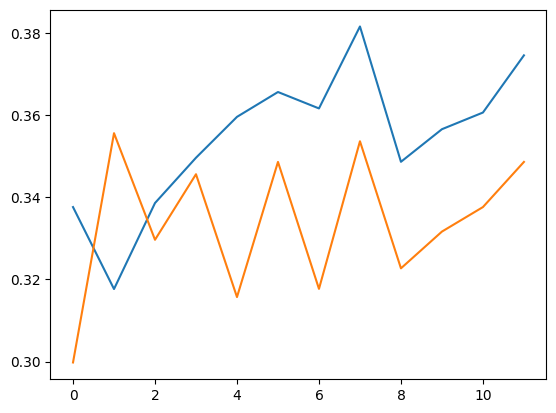

In [41]:
a0 = np.array(a).mean(axis=0)
b0 = np.array(b).mean(axis=0)
plt.plot(a0, label='VGG16')
plt.plot(b0, label='CNN')

plt.show()